## MLlib Pipelines and Structured Streaming

This notebook shows how to train an MLlib pipeline on *historic data* and apply it to *streaming data*.

You can read more about Pipeline API in the [MLlib Programming Guide](https://spark.apache.org/docs/latest/ml-guide.html).

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("LogisticRegressionExample").getOrCreate()

For this example we'll be using the Extended Modified NIST (*National Institute of Standards and Technology*) Letters dataset which is a set of **handwritten letters** derived from the NIST Special Database 19 and converted to a 28x28 pixel grayscale image format. The dataset merges a balanced set of the uppercase and lowercase letters into a single 26-class task. Further information on the dataset contents and conversion process can be found in the paper available at https://arxiv.org/abs/1702.05373v1.

![letters]( 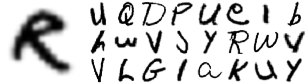)

Begin by reading the train data and inspecting the schema.

The data is stored in the popular **LibSVM** format, so the file can be loaded using MLlib's dataset reader utility.

In [ ]:
train = spark.read.format("libsvm").option("numFeatures", 784).load("data/nist/letters_libsvm_train.dat")

train.printSchema()

Every LibSVM dataset contains exactly 2 columns:
* **label**: 0 to 25. Each label represents a different letter.
* **features**: The total 784 pixels of the grayscale handwritten letter image.

We want to build a model that will predict the `label` using the `features` data. We'll do this by using a pipeline with 4 stages.
1. A `StringIndexer` to tell the algorithm that the labels are categories 0-25, rather than continuous values.
2. A `StandardScaler` to normalize each feature to have unit standard deviation and zero mean.
3. A `LogisticRegression` to perform Elastic-Net Regularization with Logistic Regression algorithm and learn how to predict labels of new examples.
3. An `IndexToString` to convert the prediction indices back to the original labels as strings.

Let's start by creating the objects that represent these stages.

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import IndexToString, StandardScaler, StringIndexer

labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(train)

featuresScaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True).fit(train)

lr = LogisticRegression(labelCol="indexedLabel", featuresCol="scaledFeatures")

indexToLabel = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)

### Logistic Regression

Logistic Regression (*LR*) training takes several hyperparameters which can affect the accuracy of the learned model. There is no one "best" setting for these for all datasets. To get the optimal accuracy, we need to tune these hyperparameters based on our data.

We will do this tuning using Spark's [Cross Validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics) framework, which automatically tests a grid of [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_optimization) and chooses the best.

We wrap the Logistic Regression model training stage within a `CrossValidator` stage. A cross validator knows how to call the LR algorithm with different hyperparameter (e.g. `elasticNetParam`) settings. It will train multiple models and choose the best one, based on some metric. In this example, our metric is `accuracy`.

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", metricName="accuracy")

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = ParamGridBuilder().addGrid(lr.elasticNetParam, [0.1, 0.3, 0.6, 0.9]).build()

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

![Pipeline]( 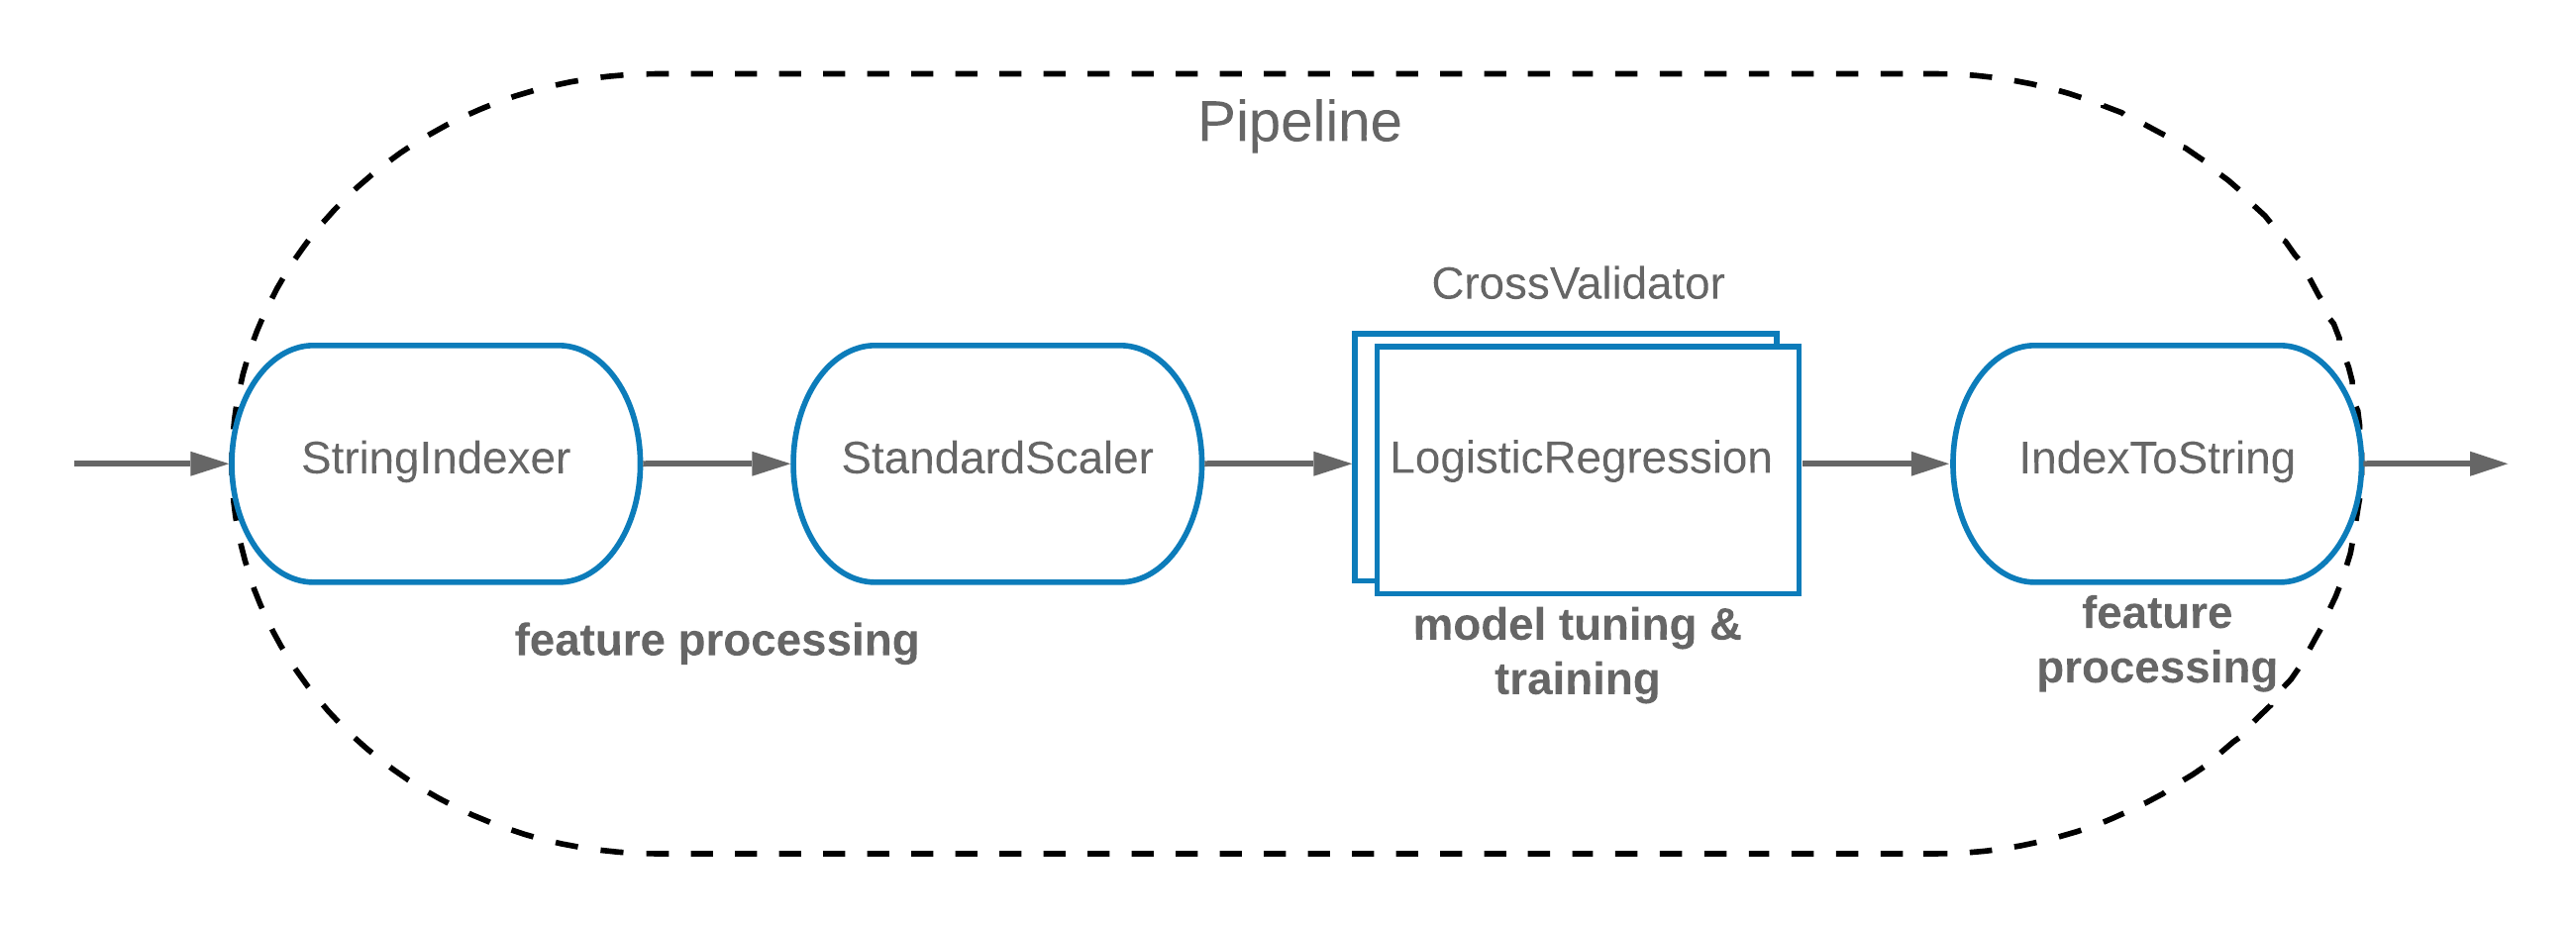)

Now we're ready to build a pipeline and fit it. This puts the data through all of the feature processing, model tuning & training we described in a single call.

In [ ]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[labelIndexer, featuresScaler, cv, indexToLabel])

%time model = pipeline.fit(train)

Since we don't have an actual stream to read from, we can simulate a stream by using Spark to read the test data as a stream. We'll use this simulated stream to do some validation of our model. Data can be ingested from many sources like Kafka, Flume, Kinesis, or TCP sockets.

In [ ]:
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField

from pyspark.sql.types import DoubleType
from pyspark.ml.linalg import VectorUDT

schema = StructType([StructField("label", DoubleType(), True), StructField("features", VectorUDT(), True)])

test = spark.readStream.schema(schema).format("parquet").load("data/nist/letters_parquet_test.dat")

To validate the model we'll write the predicted labels to a `table`, but because we're using Spark Structured Streaming this table will update in real time as more data is read from the stream.

In [ ]:
results = model.transform(test)

query = results.writeStream.queryName("table").format("memory").start()

The following SQL query calculates the accuracy of the predictions, comparing the `label` to the `predictedLabel` from the table.

In [ ]:
spark.sql("SELECT (COUNT(*) / (SELECT COUNT(*) FROM table)) AS accuracy FROM table WHERE label = predictedLabel").show()

Quit.

In [ ]:
query.stop()
spark.stop()